In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

#gamma function
from scipy import special

#Fitting the spectrum
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import fitter_unit_support
from astropy.modeling.core import Fittable1DModel, Parameter

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

#Packages for using tables and units in astropy
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

#Astropy module to handle units
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B,m_e,e

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

My first attemp to make a python class. Trying to recreate the class on astropy fitting (https://docs.astropy.org/en/stable/_modules/astropy/modeling/functional_models.html#Gaussian1D)

In [39]:
class lineal(Fittable1DModel):

    n_inputs = 1
    n_outputs = 1

    b = Parameter(
        default=0, description="Pendiente"
    )

    @property
    def evaluate(x, b):
        self.x=self.x.to(u.s)
        y=self.b*self.x
        return y
    def input_units(self):
        if self.mean.input_unit is None:
            return None
        return {self.inputs[0]: self.x.input_unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        return {
            "b": inputs_unit[self.inputs[0]],
            "y": outputs_unit[self.outputs[0]],
        }

Some GitHub code (https://github.com/astropy/astropy/issues/9889) (https://github.com/astropy/astropy/pull/10174/commits/dbe56f4ed7059df507d3fac6f12d16140e82018f) that helped a lot.

In [57]:
class  CustomInputNamesModel(Fittable1DModel):

    n_inputs = 1
    n_outputs = 1

    a = Parameter(default=1.0)
    b = Parameter(default=1.0)

    def __init__(self, a=a, b=b):
        super().__init__(a=a, b=b)
        self.inputs = ('inn',)
        self.outputs = ('out',)

    @staticmethod
    def evaluate(inn, a, b):
        return a * inn + b

    @property
    def input_units(self):
        if self.a.unit is None and self.b.unit is None:
            return None
        else:
            return {'inn': self.b.unit / self.a.unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        return {'a': outputs_unit['out'] / inputs_unit['inn'],
                'b': outputs_unit['out']
               }


def models_with_custom_names():
    line = models.Linear1D(1 * u.m / u.s, 2 * u.m)
    line.inputs = ('inn',)
    line.outputs = ('out',)

    custom_names_model = CustomInputNamesModel(1 * u.m / u.s, 2 * u.m)
    return [line, custom_names_model]

In [58]:
x1 = np.linspace(0,10,100)*u.s

b = -1*u.m/u.s
c = 1*u.m
y1 = (b*x1+c)
y1 =(y1.value + np.random.normal(0., 0.2, x1.value.shape))*u.m

exp_model = CustomInputNamesModel(-1.*u.m/u.s, 2*u.m)  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x1, y1)

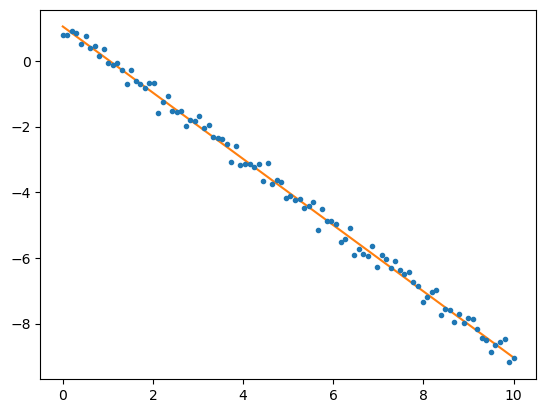

In [71]:
plt.errorbar(x1 , y1, fmt='.')
plt.plot(x1, exp_fit(x1))
plt.show()

In [54]:
def calc_reduced_chi_square(fit, x, y, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y))**2)

In [60]:
calc_reduced_chi_square(exp_fit(x1), x1, y1, len(x1), 3)

<Quantity 0.04097211 m2>

In [69]:
a=3.0*u.dimensionless_unscaled
if a.unit is None:
    a